In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import math
import scipy
import pandas as pd
from IPython.display import Image

# Generate dataset

In [11]:
def generate_data(n):
    x = torch.randn(n, 2)
    A = 0.4 + 0.4 * (1 + torch.erf(x[:, :1] / np.sqrt(2)))
    B = 0.01 + 0.15 * (1 + torch.erf(x[:, 1:] / np.sqrt(2)))
    normal = torch.randn(n, 5) * np.sqrt(1e-3)

    y_mean = A * (1 - torch.exp(-B * torch.arange(1, 6)))
    y = y_mean + normal
    return x, y

In [12]:
x, y = generate_data(50000)
data = torch.cat((x,y), dim = 1)

In [13]:
torch.mean(y, dim=0)

tensor([0.1160, 0.2106, 0.2890, 0.3532, 0.4069])

In [14]:
torch.mean(x, dim=0)

tensor([0.0014, 0.0044])

In [15]:
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

# Find a convex hull in O(N log N)
points = data.numpy()

# Returned 420 points in testing
hull = ConvexHull(points)

# Extract the points forming the hull
hullpoints = points[hull.vertices,:]

# Naive way of finding the best pair in O(H^2) time if H is number of points on
# hull
hdist = cdist(hullpoints, hullpoints, metric='euclidean')

# Get the farthest apart points
bestpair = np.unravel_index(hdist.argmax(), hdist.shape)

#Print them
print([hullpoints[bestpair[0]],hullpoints[bestpair[1]]])

[array([4.1803384 , 2.1828716 , 0.36597213, 0.50933516, 0.722934  ,
       0.8354294 , 0.9562697 ], dtype=float32), array([-3.902285  , -1.6226362 ,  0.04675064,  0.015985  ,  0.02727982,
        0.02766127,  0.06511065], dtype=float32)]


In [16]:
np.linalg.norm(hullpoints[bestpair[0]]-hullpoints[bestpair[1]])

9.060164

# Define model

In [17]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        # inputs of data (x1,x2,y1,y2,y3,y4,y5), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(8, int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units), bias=True),
            nn.ReLU(),
            nn.Linear(int(self.hidden_units), 7, bias=True)
        )
        
    def forward(self, x):
        t = x[:, -1]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [21]:
sum(p.numel() for p in score_model.parameters())

30151

# Set up SDE

In [19]:
device = 'cpu'

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return 0.01 * (sigma / 0.01)**t
  
sigma =  9.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [20]:
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)

# Loss function

In [25]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [244]:
epochs = 40
batch_size = 64
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = data
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/BOD.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-239-ac7843055b74>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


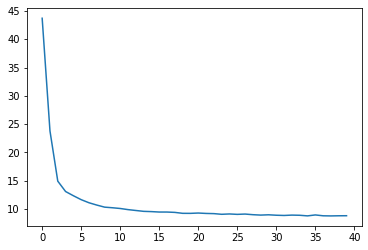

In [245]:
plt.plot(losses)

# PC sampler

In [246]:
signal_to_noise_ratio = 0.16 

num_steps =  500
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=10000, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cpu',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 7, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      

    # The last step does not include any noise
    return x_mean

In [247]:
ckpt = torch.load('models/BOD.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [248]:
pc_samples = pc_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn)

<ipython-input-239-ac7843055b74>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

In [249]:
torch.mean(pc_samples, axis=0)

tensor([-0.0720, -0.0589,  0.1029,  0.1977,  0.2938,  0.3548,  0.4029])

In [250]:
torch.mean(data, axis=0)

tensor([0.0056, 0.0053, 0.1162, 0.2112, 0.2892, 0.3542, 0.4078])

In [251]:
torch.var(pc_samples, axis=0)

tensor([1.1208, 1.1440, 0.0403, 0.0503, 0.0615, 0.0707, 0.0812])

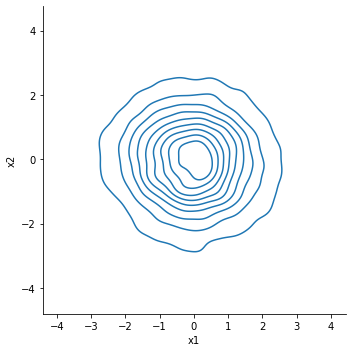

In [252]:
gen_data = pd.DataFrame(pc_samples.numpy())
gen_data.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']
sns.displot(gen_data, x ='x1', y='x2', kind="kde")

<hr style="border:2px solid black">

# CDiffE replacement method

In [292]:
def get_y_t(y_obs, t):
    std = marginal_prob_std_fn(t)
    z = torch.randn_like(y_obs)
    perturbed_y = y_obs + z * std[:, None]
    return perturbed_y

In [26]:
def get_y_t(y_obs, t):
    p = (sigma/0.01)**t.reshape(t.shape[0], 1)
    return torch.randn(t.shape[0], y_obs.shape[0])*0.01*p + y_obs

In [168]:
num_steps =  1000
def CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=10000, 
                           num_steps=num_steps, 
                           eps=1e-4):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 7) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            
            batch_time_step = torch.ones(batch_size) * time_step
            y_obs_t = get_y_t(y_obs, batch_time_step)

            x = torch.hstack([x,y_obs_t])[:, [0,1,7,8,9,10,11]]

            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 

    return mean_x

In [303]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDiffE_pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               y_obs,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,
               eps=1e-5):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 7) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    diffused_y = [i.repeat(batch_size).reshape(batch_size,5) for i in get_diffused_y(y_obs, time_steps)]
    with torch.no_grad(): 
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x = torch.hstack([x,y_obs_t])[:, [0,1,7,8,9,10,11]]
            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            mu, sd = get_next_x(x, batch_size, score_model, diffusion_coeff, time_step, step_size)
            x = mu + sd * torch.randn_like(x) 
            
    return x

In [304]:
y_obs = torch.tensor([0.18, 0.32, 0.42, 0.49, 0.54])

In [305]:
ckpt = torch.load('models/BOD.pth', map_location=device)
score_model.load_state_dict(ckpt)
cdiffe_samples = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000)

<ipython-input-19-ac7843055b74>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [306]:
test = pd.DataFrame(cdiffe_samples.numpy())
test.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']

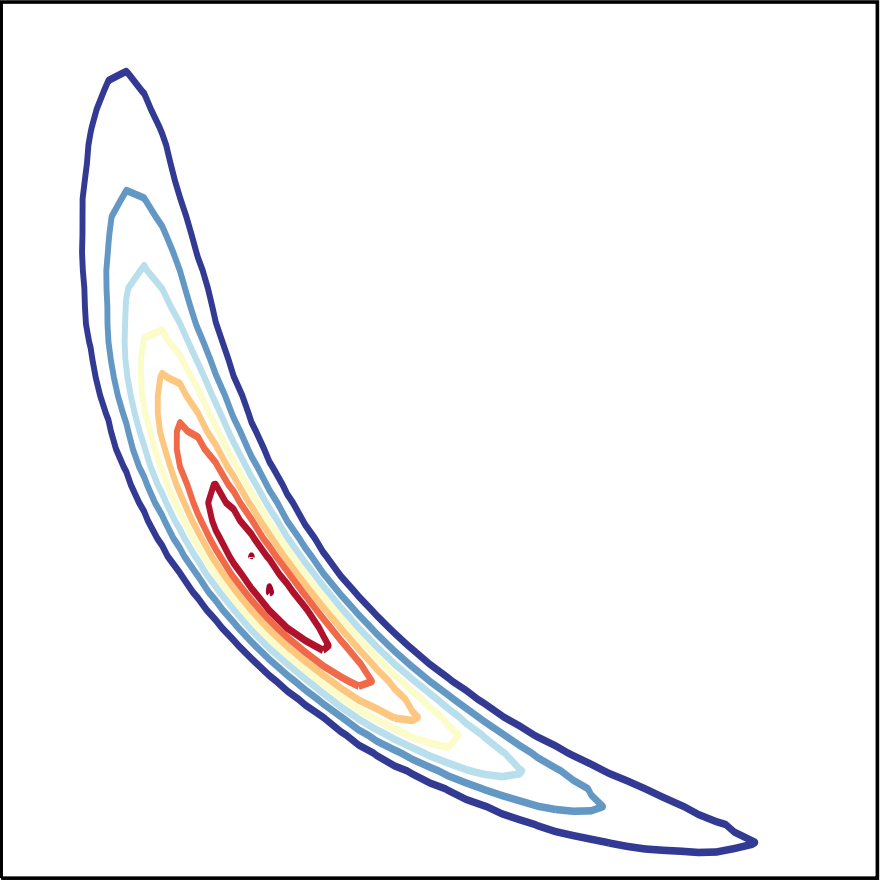

In [307]:
Image("BOD target density.png", width=300, height=300)

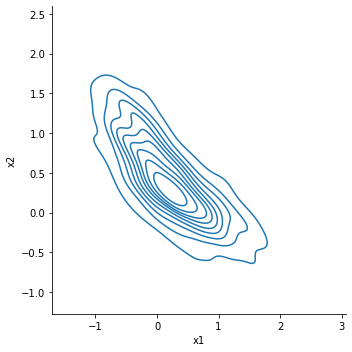

In [308]:
sns.displot(test, x ='x1', y='x2', kind="kde")

In [309]:
torch.mean(cdiffe_samples, axis=0)

tensor([0.1864, 0.4257, 0.1756, 0.3139, 0.4172, 0.4884, 0.5392])

In [310]:
torch.var(cdiffe_samples, axis=0)

tensor([3.0601e-01, 2.2618e-01, 9.8953e-05, 1.1661e-04, 1.1841e-04, 1.3624e-04,
        1.5010e-04])

In [311]:
scipy.stats.skew(cdiffe_samples[:, [0,1]])

array([0.423284  , 0.50559646], dtype=float32)

In [312]:
scipy.stats.kurtosis(cdiffe_samples[:, [0,1]])

array([0.15348911, 0.05123329], dtype=float32)

<hr style="border:2px solid black">

# CDE tailored conditional method

In [56]:
def CDE_loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    y = x[:,[2,3,4,5,6]]
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    perturbed_x = torch.hstack([perturbed_x,y])
    perturbed_x = perturbed_x[:, [0,1,7,8,9,10,11]]
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [326]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDE_pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               y_obs,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,5)
    x = torch.hstack([init_x, y_obs])
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):
        
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            mu, sd = get_next_x(x, batch_size, score_model, diffusion_coeff, time_step, torch.tensor(step_size))
            x = mu + sd * torch.randn_like(x) 
            
            #conditional info
            x = torch.hstack([x,y_obs])
            x = x[:, [0,1,7,8,9,10,11]]

    return x

In [276]:
epochs = 100
batch_size = 100
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = data
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_BOD.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-239-ac7843055b74>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


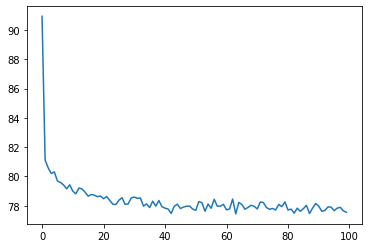

In [277]:
plt.plot(losses)

In [327]:
ckpt = torch.load('models/cde_BOD.pth', map_location=device)
score_model.load_state_dict(ckpt)
cde_samples = CDE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, batch_size = 1000)

<ipython-input-19-ac7843055b74>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [328]:
test = pd.DataFrame(cde_samples.numpy())
test.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']

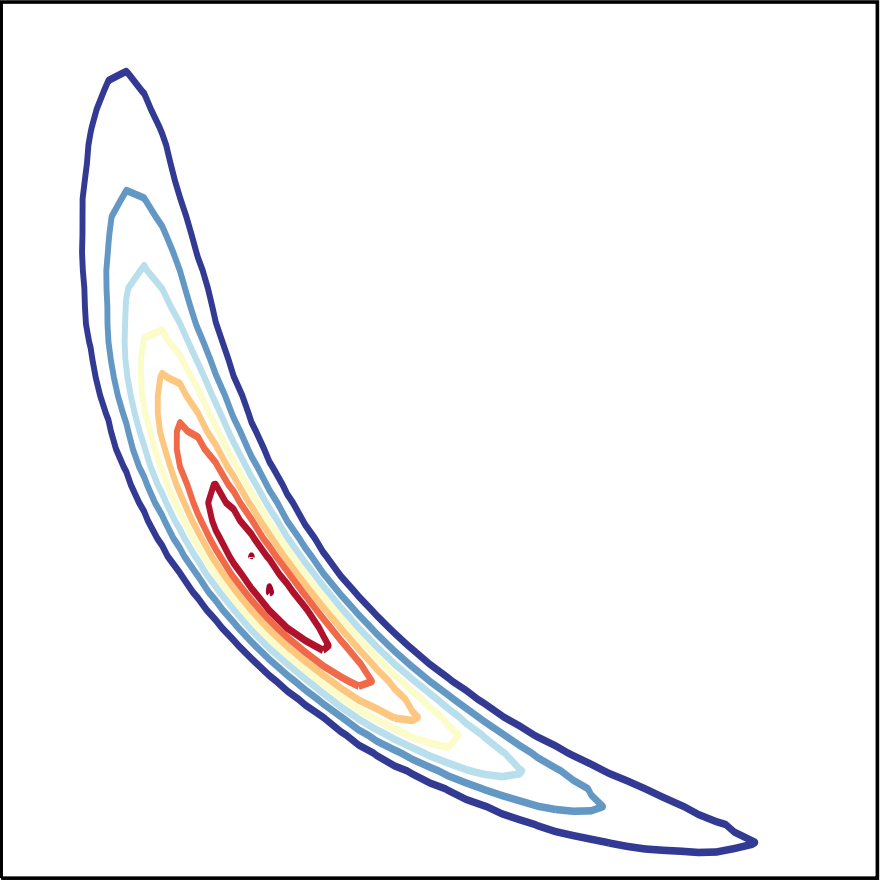

In [329]:
Image("BOD target density.png", width=300, height=300)
#make my own version with scale? would need to generate MCMC points

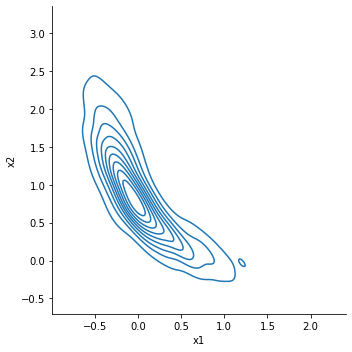

In [330]:
sns.displot(test, x ='x1', y='x2', kind="kde")

In [331]:
torch.mean(cde_samples, axis=0)

tensor([0.0083, 0.8808, 0.1800, 0.3200, 0.4200, 0.4900, 0.5400])

In [323]:
torch.var(cde_samples, axis=0)

tensor([0.1115, 0.3162, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [324]:
scipy.stats.skew(cde_samples[:,[0,1]])

array([1.3189982, 0.5643637], dtype=float32)

In [325]:
scipy.stats.kurtosis(cde_samples[:,[0,1]])

array([2.773756  , 0.09892249], dtype=float32)

<hr style="border:2px solid black">

# SMCDiff method

In [66]:
def get_next_x(x, batch_size, score_model, diffusion_coeff, time_step, step_size):
    #returns the predicted (x_{t-1}, y_{t-1}) based on the current diffused (x_t, y_t)
    batch_time_step = torch.ones(batch_size) * time_step
    g = diffusion_coeff(batch_time_step)
    batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
    x_with_t = torch.hstack([x, batch_time_step_])
    mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
    sd = torch.sqrt(step_size) * g[:, None]
    return mean_x, sd

In [67]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    diffused_y = [y_obs]
    num_steps = timesteps.shape[0]
    dt = 1 / num_steps
    g = diffusion_coeff_fn(timesteps)
    for i in range(num_steps-1):
        g_i = g[i]
        z = np.random.normal(0,1)
        y_i = diffused_y[-1] + g_i * np.sqrt(dt) * z
        diffused_y.append(y_i)
    return diffused_y

In [106]:
def get_log_w(y, mean, sd):
    norm = np.linalg.norm(y-mean, axis=1)
    return -np.divide(norm, (2*(sd[0]**2)))

In [334]:
def SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, 
                                   num_steps=1000, eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    y_obs: A tensor of the conditional y information
    k: The number of particles used in particle filtering
    batch_size: The number of samples to generate by calling this function once.
    num_steps: The number of sampling steps. Equivalent to the number of discretized time steps.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(k)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)/k
    xs = []
    init_x = torch.randn(k, 7) * marginal_prob_std(t)[:, None]
    xs.append(init_x)
    diffused_y = [i.repeat(k).reshape(k,5) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            batch_time_step = torch.ones(k) * time_step
            y_obs_t = diffused_y[idx]
            x = xs[-1]
            x = torch.hstack([x,y_obs_t])[:, [0,1,7,8,9,10,11]]
            
            #get predicted y_{t-1}
            if (idx - 1) >= 0:
                y_update_mean, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
                y_update_mean = y_update_mean[:,[2,3,4,5,6]]
                #get probability of this compared to actual y_{t-1}
                y_update_actual = diffused_y[idx-1]

                # compute un-normalized weighting factor for importance resampling step
                log_w = get_log_w(y_update_actual, y_update_mean, sd)
                #log_w = -np.divide(np.power(y_update_actual-y_update_mean, 2), (2*(sd[0]**2)))
                log_w -= torch.logsumexp(log_w, 0)

                # Update Self-normalized importance weights
                weights = torch.exp(log_w).cpu().detach().numpy()
                weights /= sum(weights) # Re-normalize
                
                resample_index = residual(weights)
                x = x[resample_index]
                weights = np.ones_like(weights)
            
            mu, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
            x_t_1 = mu + sd * torch.randn_like(x) 
            xs.append(x_t_1)

    return xs[-1]

In [109]:
def residual(W):
    """Residual resampling.
    """
    N = W.shape[0]
    M = N
    A = np.empty(M, dtype=np.int64)
    MW = M * W
    intpart = np.floor(MW).astype(np.int64)
    sip = np.sum(intpart)
    res = MW - intpart
    sres = M - sip
    A[:sip] = np.arange(N).repeat(intpart)
    # each particle n is repeated intpart[n] times
    if sres > 0:
        A[sip:] = multinomial(res / sres, M=sres)
    return A

In [110]:
def multinomial(W, M):
    """Multinomial resampling.

    Popular resampling scheme, which amounts to sample N independently from
    the multinomial distribution that generates n with probability W^n. 

    This resampling scheme is *not* recommended for various reasons; basically
    schemes like stratified / systematic / SSP tends to introduce less noise,
    and may be faster too (in particular systematic). 
    """
    return inverse_cdf(uniform_spacings(M), W)

In [111]:
def uniform_spacings(N):
    """Generate ordered uniform variates in O(N) time.

    Parameters
    ----------
    N: int (>0)
        the expected number of uniform variates

    Returns
    -------
    (N,) float ndarray
        the N ordered variates (ascending order)

    Note
    ----
    This is equivalent to::

        from numpy import random
        u = sort(random.rand(N))

    but the line above has complexity O(N*log(N)), whereas the algorithm
    used here has complexity O(N).

    """
    z = np.cumsum(-np.log(np.random.rand(N + 1)))
    return z[:-1] / z[-1]

In [130]:
def inverse_cdf(su, W):
    """Inverse CDF algorithm for a finite distribution.

        Parameters
        ----------
        su: (M,) ndarray
            M sorted uniform variates (i.e. M ordered points in [0,1]).
        W: (N,) ndarray
            a vector of N normalized weights (>=0 and sum to one)

        Returns
        -------
        A: (M,) ndarray
            a vector of M indices in range 0, ..., N-1
    """
    j = 0
    s = W[0]
    M = su.shape[0]
    A = np.empty(M, dtype=np.int64)
    for n in range(M):
        while su[n] > s:
            if j < W.shape[0]-1:
                j += 1
            s += W[j]
        A[n] = j
    return A

In [335]:
ckpt = torch.load('models/BOD.pth', map_location=device)
score_model.load_state_dict(ckpt)

smcdiff_samples = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = y_obs, k = 1000)

<ipython-input-19-ac7843055b74>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([-2.6299, -2.6568, -2.6633, -2.6597, -2.5986, -2.6431, -2.6782, -2.6625,
        -2.6295, -2.6658, -2.6797, -2.6034, -2.6464, -2.6178, -2.6450, -2.6130,
        -2.6439, -2.6167, -2.6683, -2.6567, -2.6772, -2.6664, -2.6713, -2.6212,
        -2.6784, -2.6120, -2.6608, -2.6494, -2.6833, -2.6562, -2.6003, -2.6332,
        -2.6841, -2.6506, -2.5589, -2.6181, -2.6240, -2.6356, -2.6813, -2.6487,
        -2.6435, -2.6435, -2.6589, -2.6619, -2.6604, -2.6482, -2.6849, -2.6653,
        -2.6529, -2.6761, -2.6721, -2.6130, -2.6640, -2.6697, -2.6697, -2.6099,
        -2.6634, -2.6139, -2.6580, -2.6624, -2.6775, -2.6248, -2.6178, -2.6204,
        -2.6193, -2.6528, -2.6105, -2.6189, -2.6576, -2.6534, -2.6352, -2.6693,
        -2.6598, -2.6188, -2.6704, -2.6484, -2.6690, -2.6278, -2.6620, -2.6843,
        -2.6583, -2.6467, -2.6189, -2.6611, -2.6011, -2.6721, -2.6784, -2.6769,
        -2.6528, -2.6587, -2.6617, -2.6754, -2.6206, -2.6126, -2.6512, -2.6633,
        -2.6229, -2.6635, -2.6670, -2.65

tensor([-1.3760, -1.3755, -1.3830, -1.3822, -1.3780, -1.3727, -1.3745, -1.3797,
        -1.3748, -1.3766, -1.3734, -1.3746, -1.3765, -1.3770, -1.3817, -1.3825,
        -1.3761, -1.3725, -1.3763, -1.3798, -1.3769, -1.3754, -1.3741, -1.3835,
        -1.3789, -1.3768, -1.3716, -1.3827, -1.3807, -1.3810, -1.3802, -1.3719,
        -1.3774, -1.3815, -1.3747, -1.3814, -1.3838, -1.3862, -1.3845, -1.3920,
        -1.3906, -1.3910, -1.3794, -1.3747, -1.3971, -1.3894, -1.3926, -1.3935,
        -1.3922, -1.3890, -1.3883, -1.3931, -1.3924, -1.3895, -1.3931, -1.3957,
        -1.3867, -1.3950, -1.3878, -1.3897, -1.3900, -1.3885, -1.3877, -1.3998,
        -1.4009, -1.4019, -1.4046, -1.4033, -1.4018, -1.4028, -1.4031, -1.3968,
        -1.3840, -1.3891, -1.3876, -1.3882, -1.3897, -1.3884, -1.4090, -1.4109,
        -1.4189, -1.4152, -1.4015, -1.3951, -1.3947, -1.3985, -1.3995, -1.3967,
        -1.4004, -1.3933, -1.3864, -1.3883, -1.3904, -1.3888, -1.3921, -1.3865,
        -1.3872, -1.3880, -1.3896, -1.37

tensor([-7.0057, -7.0010, -7.0004, -7.0080, -7.0046, -7.0052, -7.0092, -7.0048,
        -7.0067, -6.9952, -7.0006, -7.0002, -7.0156, -6.9971, -7.0005, -7.0054,
        -7.0045, -7.0045, -7.0041, -7.0076, -7.0030, -7.0010, -6.9939, -6.9991,
        -7.0090, -7.0046, -7.0065, -7.0009, -6.9940, -6.9933, -6.9946, -6.9955,
        -6.9995, -6.9930, -7.0059, -6.9989, -6.9989, -7.0042, -6.9864, -6.9942,
        -6.9863, -6.9824, -6.9875, -6.9849, -7.0040, -6.9950, -6.9973, -6.9943,
        -6.9976, -6.9972, -6.9932, -6.9946, -6.9887, -6.9872, -6.9984, -6.9932,
        -6.9973, -6.9934, -6.9913, -6.9952, -6.9955, -6.9966, -7.0032, -6.9964,
        -7.0022, -7.0005, -6.9928, -6.9956, -6.9969, -6.9981, -6.9939, -6.9941,
        -6.9986, -6.9841, -6.9853, -6.9834, -6.9824, -7.0054, -6.9908, -6.9897,
        -6.9868, -6.9886, -6.9887, -6.9869, -6.9892, -6.9893, -6.9871, -6.9865,
        -6.9851, -6.9907, -6.9854, -6.9833, -6.9848, -6.9884, -6.9870, -6.9923,
        -6.9876, -6.9915, -6.9860, -6.97

tensor([-3.5802, -3.5787, -3.5749, -3.5878, -3.5819, -3.5806, -3.5830, -3.5904,
        -3.5807, -3.5826, -3.5857, -3.5833, -3.5846, -3.5880, -3.5853, -3.5865,
        -3.5855, -3.6029, -3.6031, -3.6162, -3.6210, -3.5838, -3.5936, -3.5868,
        -3.5858, -3.5803, -3.5794, -3.5828, -3.6057, -3.5943, -3.5837, -3.5869,
        -3.5848, -3.5860, -3.5718, -3.5837, -3.5873, -3.5844, -3.5825, -3.5818,
        -3.5824, -3.5923, -3.5904, -3.5907, -3.5890, -3.5934, -3.5926, -3.5988,
        -3.5921, -3.5881, -3.5871, -3.5862, -3.5850, -3.5802, -3.5892, -3.6039,
        -3.5952, -3.5938, -3.5855, -3.5968, -3.5939, -3.5909, -3.5972, -3.5943,
        -3.5950, -3.5936, -3.5929, -3.5971, -3.5951, -3.5934, -3.5905, -3.5943,
        -3.6032, -3.5942, -3.5915, -3.5962, -3.5941, -3.5933, -3.5958, -3.5973,
        -3.5817, -3.6062, -3.5859, -3.5978, -3.6018, -3.6069, -3.6026, -3.6013,
        -3.6079, -3.6021, -3.6079, -3.6065, -3.6018, -3.6075, -3.6112, -3.6261,
        -3.6206, -3.6236, -3.6240, -3.62

tensor([-4.4580, -4.4523, -4.4636, -4.4781, -4.4721, -4.4623, -4.4640, -4.4653,
        -4.4803, -4.4780, -4.4557, -4.4535, -4.4510, -4.4797, -4.4513, -4.4748,
        -4.4616, -4.4630, -4.4700, -4.4564, -4.4622, -4.4563, -4.4584, -4.4689,
        -4.4787, -4.4776, -4.4671, -4.4759, -4.4758, -4.4765, -4.4804, -4.4777,
        -4.4590, -4.4756, -4.4571, -4.4748, -4.4673, -4.4770, -4.4779, -4.4792,
        -4.4753, -4.4708, -4.5164, -4.5032, -4.4641, -4.4560, -4.4777, -4.4783,
        -4.4737, -4.4927, -4.4737, -4.5220, -4.5230, -4.4815, -4.4661, -4.4615,
        -4.4621, -4.4681, -4.4703, -4.4571, -4.4521, -4.4672, -4.4635, -4.4672,
        -4.4471, -4.4537, -4.4538, -4.4632, -4.4568, -4.4554, -4.4956, -4.4879,
        -4.4837, -4.4862, -4.4877, -4.5109, -4.5123, -4.4991, -4.4930, -4.4838,
        -4.4826, -4.4999, -4.4809, -4.4827, -4.4812, -4.4803, -4.4735, -4.4660,
        -4.4644, -4.4536, -4.4743, -4.4596, -4.4598, -4.4595, -4.4754, -4.4605,
        -4.4974, -4.4673, -4.4552, -4.45

tensor([-6.9100, -6.9064, -6.9091, -6.9014, -6.9148, -6.9138, -6.9118, -6.9103,
        -6.9056, -6.9030, -6.9146, -6.9074, -6.9071, -6.9043, -6.9114, -6.9234,
        -6.9232, -6.9108, -6.9104, -6.9105, -6.9100, -6.9176, -6.9146, -6.9130,
        -6.9113, -6.9217, -6.9102, -6.9068, -6.9113, -6.9080, -6.9106, -6.9140,
        -6.9135, -6.9210, -6.9110, -6.9223, -6.9101, -6.9211, -6.9212, -6.9212,
        -6.9159, -6.9213, -6.9214, -6.9208, -6.9177, -6.9227, -6.9269, -6.9259,
        -6.9216, -6.9220, -6.9189, -6.9128, -6.9185, -6.9172, -6.9211, -6.9137,
        -6.9229, -6.9172, -6.9164, -6.9182, -6.9116, -6.9138, -6.9207, -6.9213,
        -6.9235, -6.9221, -6.9246, -6.9287, -6.9317, -6.9315, -6.9298, -6.9306,
        -6.9287, -6.9250, -6.9246, -6.9240, -6.9241, -6.9227, -6.9228, -6.9232,
        -6.9227, -6.9246, -6.9233, -6.9210, -6.9237, -6.9255, -6.9272, -6.9268,
        -6.9241, -6.9255, -6.9302, -6.9316, -6.9303, -6.9284, -6.9284, -6.9228,
        -6.9241, -6.9231, -6.9225, -6.92

KeyboardInterrupt: 

In [224]:
smc_df = pd.DataFrame(smcdiff_samples.numpy())
smc_df.columns =['x1', 'x2', 'y1', 'y2', 'y3', 'y4', 'y5']

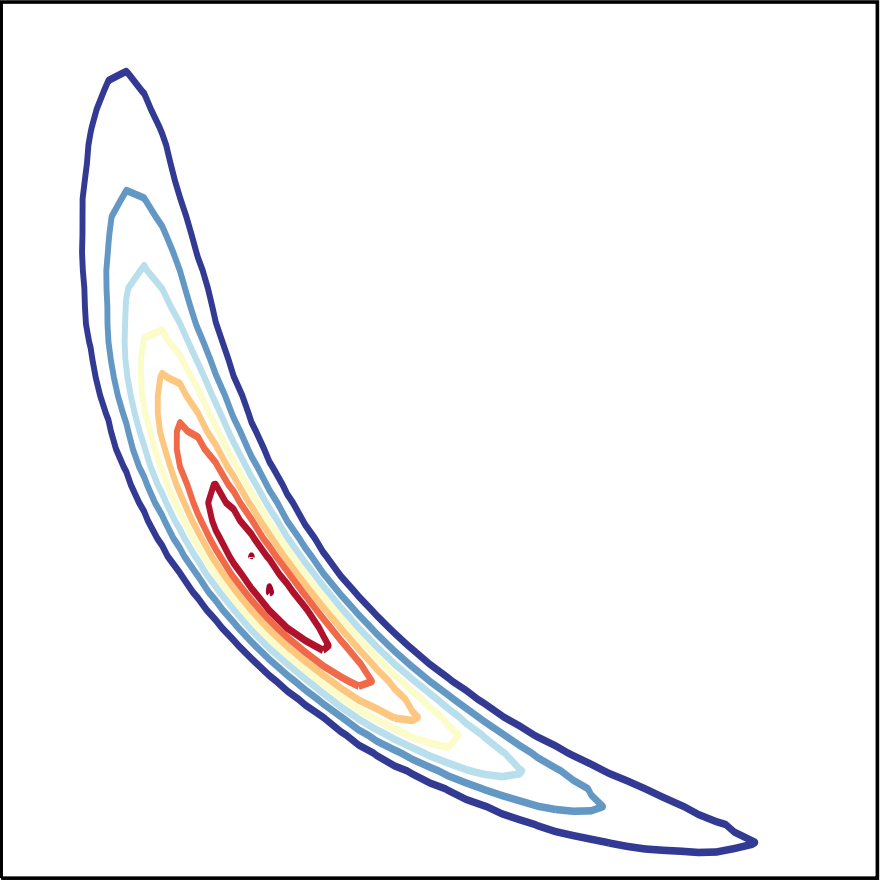

In [225]:
Image("BOD target density.png", width=300, height=300)
#make my own version with scale? would need to generate MCMC points

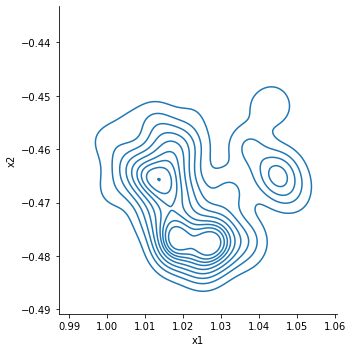

In [226]:
sns.displot(smc_df, x ='x1', y='x2', kind="kde")

In [227]:
torch.mean(smcdiff_samples, axis=0)

tensor([ 1.0223, -0.4694,  0.1800,  0.3200,  0.4200,  0.4900,  0.5400])

In [228]:
torch.var(smcdiff_samples, axis=0)

tensor([1.1711e-04, 6.5369e-05, 1.0397e-07, 9.9839e-08, 9.6759e-08, 9.6163e-08,
        1.0310e-07])

In [149]:
scipy.stats.skew(smcdiff_samples[:,[0,1]])

array([-0.58771807, -0.21307506], dtype=float32)

In [150]:
scipy.stats.kurtosis(smcdiff_samples[:,[0,1]])

array([-0.30095935,  0.51031995], dtype=float32)